<a href="https://colab.research.google.com/github/GMobinit/cat_dog_recognition_model/blob/VGG_model/cat_dog_recognition_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [2]:
## Upload your kaggle credentials to content directroy
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 96% 755M/787M [00:06<00:00, 102MB/s] 
100% 787M/787M [00:06<00:00, 120MB/s]


In [4]:
import tensorflow as tf
import zipfile

In [5]:
zipfile.ZipFile('kaggle-cat-vs-dog-dataset.zip', 'r').extractall('dataset')

In [6]:
import pathlib
data_dir = pathlib.Path('dataset/kagglecatsanddogs_3367a/PetImages').with_suffix('')

In [7]:
cat_image_count = len(list(data_dir.glob('Cat/*')))
dog_image_count = len(list(data_dir.glob('Dog/*')))
print(f"cat image count: {cat_image_count}, dog image count: {dog_image_count}, all images: {cat_image_count+dog_image_count}")

cat image count: 12491, dog image count: 12470, all images: 24961


In [8]:
import PIL

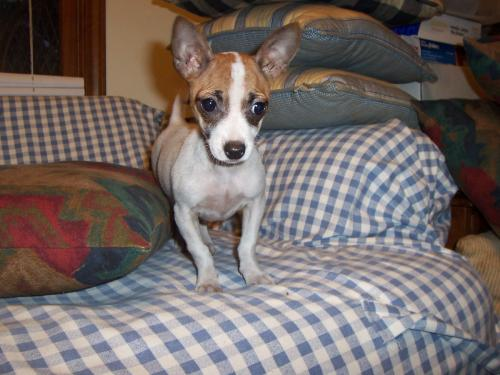

In [12]:
PIL.Image.open(str(list(data_dir.glob('Dog/*'))[0]))

In [28]:
list_ds  = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(cat_image_count+dog_image_count, reshuffle_each_iteration=False)

In [30]:
for file_add in list_ds.take(5):
  print(file_add)

tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Dog/10288.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Cat/5385.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Cat/9702.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Cat/11389.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/kagglecatsanddogs_3367a/PetImages/Dog/6885.jpg', shape=(), dtype=string)


In [34]:
labels = []
for item in data_dir.glob('*'):
  labels.append(item.name)

print(labels)

['Dog', 'Cat']


In [39]:
## train validation split
validation_percentage = 0.2
validation_size = int((cat_image_count+dog_image_count)*validation_percentage)

validation_ds = list_ds.take(validation_size)
train_ds = list_ds.skip(validation_size)

print(f'validation size {tf.data.experimental.cardinality(validation_ds)}, train size {len(train_ds)}')

validation size 4992, train size 19969


In [ ]:
def get_label()